# Discrete frame-level seq2seq autoencoders

Ryan Eloff, ryan.peter.eloff@gmail.com, February 2019.

_(Last updated: 14 February 2019 --- might not match src train/test scripts)_

Based on code from the following paper:
- H. Kamper, "Truly unsupervised acoustic word embeddings using weak top-down constraints in encoder-decoder models," *arXiv preprint arXiv:1811.00403*, 2018. [[arXiv](https://arxiv.org/abs/1811.00403)][[code](https://github.com/kamperh/recipe_bucktsong_awe)]

### Preamble

Re-load all modules before executing Python cells, and use the matplotlib 'inline' backend:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import os
import sys

In [4]:
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [5]:
sys.path.append(os.path.join("..", "src"))
sys.path.append(os.path.join("..", "embeddings"))

In [6]:
from constants import TF_FLOAT_DTYPE
from constants import TF_INT_DTYPE
from constants import NP_FLOAT_DTYPE
from constants import NP_INT_DTYPE
from tf_base.models import ae
from tf_base.models import rnn
from tf_base import training
from tf_base import vis
from utils import batching

In [7]:
output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Load data

In [8]:
def read_npz(npz, quiet=True):
    keys = []
    x = []
    x_lengths = []
    speakers = []
    num_data = 0
    for utterance_key in sorted(npz.keys()):    
        # process next utterance
        data = npz[utterance_key]
        length = data.shape[0]
        speaker = utterance_key.split('_')[0]
        # store utterance data
        x.append(data)
        x_lengths.append(length)
        keys.append(utterance_key)
        speakers.append(speaker)
        num_data += 1
    if not quiet:
        print("Example key:", npz.files[0])
        print("No. of utterances in npz:", num_data)
    return {"keys": np.asarray(keys),
            "x": np.asarray(x),
            "x_lengths": np.asarray(x_lengths),
            "speakers": np.asarray(speakers)}

In [10]:
language = "english"  # one of "english" or "surprise"
input_feats = "mfcc"  # one of "mfcc" or "fbank"
output_feats = "fbank"  # one of "mfcc" or "fbank"
seq_type = "unsegmented_to_fftnet"  # one of "segments", "unsegmented", "fftnet_segments", "unsegmented_to_fftnet",  
max_length = 2000  # length at which segments are truncated
split_length = 500  # length at which segments are split for VQ-VAE

feats_dir = os.path.join("..", "features")
mfcc_dir = os.path.join(feats_dir, "mfcc", language)
fbank_dir = os.path.join(feats_dir, "fbank", language)

# Load npz data (sorted keys of mfcc and fbank train/test are the same):
if seq_type is "segments":  # load segmented utterances (from forced alignments provided by ZeroSpeech2019)
    mfcc_train_npz = np.load(os.path.join(mfcc_dir, "train.dd.npz"))
    mfcc_test_npz = np.load(os.path.join(mfcc_dir, "test.dd.npz"))
    fbank_train_npz = np.load(os.path.join(fbank_dir, "train.npz"))
    fbank_test_npz = np.load(os.path.join(fbank_dir, "test.npz"))
elif seq_type is "unsegmented":
    mfcc_train_npz = np.load(os.path.join(mfcc_dir, "train_unsegmented_1.dd.npz"))
    mfcc_test_npz = np.load(os.path.join(mfcc_dir, "test_unsegmented_1.dd.npz"))
    fbank_train_npz = np.load(os.path.join(fbank_dir, "train_unsegmented_1.npz"))
    fbank_test_npz = np.load(os.path.join(fbank_dir, "test_unsegmented_1.npz"))
elif seq_type is "fftnet_segments":
    mfcc_train_npz = np.load(os.path.join(mfcc_dir, "unsegmented_train_mfcc_normalized.npz"))
    mfcc_test_npz = np.load(os.path.join(mfcc_dir, "test_unsegmented_1.dd.npz"))
    fbank_train_npz = np.load(os.path.join(fbank_dir, "unsegmented_train_fbank_fftnet.npz"))
    fbank_test_npz = np.load(os.path.join(fbank_dir, "unsegmented_test_fbank_fftnet.npz.npz"))
elif seq_type is "unsegmented_to_fftnet":  # unsegmented 13 dim mfcc to fftnet fbank segments
    mfcc_train_npz = np.load(os.path.join(mfcc_dir, "train_unsegmented_1.dd.npz"))
    mfcc_test_npz = np.load(os.path.join(mfcc_dir, "test_unsegmented_1.dd.npz"))
    fbank_train_npz = np.load(os.path.join(fbank_dir, "unsegmented_train_fbank_fftnet.npz"))
    fbank_test_npz = np.load(os.path.join(fbank_dir, "unsegmented_test_fbank_fftnet.npz"))
else:
    raise ValueError("Invalid sequence type: {}".format(seq_type))

# Read input data
if input_feats is "mfcc":
    input_train = read_npz(mfcc_train_npz, quiet=False)
    input_test = read_npz(mfcc_test_npz, quiet=False)
    dim_input_feats = input_train["x"][0].shape[-1] if seq_type is "fftnet_segments" else 13  # remove MFCC delta & delta-delta
else:  # fbank
    input_train = read_npz(fbank_train_npz, quiet=False)
    input_test = read_npz(fbank_test_npz, quiet=False)
    dim_input_feats = input_train["x"][0].shape[-1]  # full feature dimensionality
    
# Read reconstruction output data
if output_feats is "mfcc":
    output_train = read_npz(mfcc_train_npz, quiet=False)
    output_test = read_npz(mfcc_test_npz, quiet=False)
    dim_output_feats = output_train["x"][0].shape[-1] if seq_type is "fftnet_segments" else 13  # remove MFCC delta & delta-delta
else:  # fbank
    output_train = read_npz(fbank_train_npz, quiet=False)
    output_test = read_npz(fbank_test_npz, quiet=False)
    dim_output_feats = output_train["x"][0].shape[-1]  # full feature dimensionality

# Match number of frames in input and output feats
for train_key in zip(sorted(input_train["x"].keys())):
    match_frames = min(len(input_train["x"][train_key]), len(output_train[train_key]))
    if len(input_train[train_key]) != match_frames:
        print(len(input_train[train_key]), match_frames)
    if len(output_train[train_key]) != match_frames:
        print(len(output_train[train_key]), match_frames)
    input_train[train_key] = input_train[train_key][:match_frames, :]
    output_train[train_key] = output_train[train_key][:match_frames, :]


Example key: S015_0361841101
No. of utterances in npz: 9474
Example key: S002_0006942614
No. of utterances in npz: 13529
Example key: S015_0361841101
No. of utterances in npz: 9474
Example key: S002_0006942614
No. of utterances in npz: 13529


KeyError: ('keys',)

In [10]:
print("E.g. item shape:", input_train["x"][0].shape)

E.g. item shape: (1312, 39)


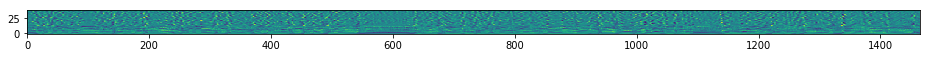

In [11]:
plt.figure(figsize=(16, 6))
plt.imshow(input_train["x"][4747].T, origin="bottom")

In [12]:
# Convert speakers to integers
all_speakers = set(input_train["speakers"]) | set(input_test["speakers"])  # union speaker sets
speaker_to_id = {}  # speaker->id lookup
id_to_speaker = {}  # id->speaker lookup
for index, speaker in enumerate(sorted(list(all_speakers))):
    speaker_to_id[speaker] = index
    id_to_speaker[index] = speaker
    
# Get train speaker ids
train_speaker_ids = []
for speaker in input_train["speakers"]:
    train_speaker_ids.append(speaker_to_id[speaker])
train_speaker_ids = np.array(train_speaker_ids, dtype=NP_INT_DTYPE)

# Get test speaker ids
test_speaker_ids = []
for speaker in input_test["speakers"]:
    test_speaker_ids.append(speaker_to_id[speaker])
test_speaker_ids = np.array(test_speaker_ids, dtype=NP_INT_DTYPE)

speaker_gender_dict = {
    # ...?
}
print(all_speakers)

{'S091', 'S069', 'S015', 'S011', 'S030', 'S021', 'S032', 'S075', 'S123', 'S106', 'S061', 'S065', 'S027', 'V002', 'S095', 'S085', 'S049', 'S129', 'S050', 'S084', 'S054', 'S062', 'S107', 'S037', 'S099', 'S071', 'S133', 'S119', 'S089', 'V001', 'S023', 'S008', 'S118', 'S093', 'S115', 'S005', 'S034', 'S111', 'S092', 'S090', 'S029', 'S082', 'S116', 'S080', 'S040', 'S126', 'S033', 'S042', 'S096', 'S020', 'S038', 'S051', 'S130', 'S087', 'S064', 'S045', 'S056', 'S108', 'S031', 'S047', 'S013', 'S035', 'S117', 'S003', 'S074', 'S068', 'S057', 'S070', 'S102', 'S007', 'S081', 'S114', 'S072', 'S131', 'S046', 'S043', 'S055', 'S066', 'S077', 'S094', 'S078', 'S127', 'S002', 'S083', 'S109', 'S059', 'S098', 'S122', 'S041', 'S076', 'S113', 'S112', 'S073', 'S105', 'S016', 'S048', 'S058', 'S120', 'S006', 'S097', 'S101', 'S036', 'S022', 'S044', 'S125', 'S121', 'S067', 'S053', 'S110', 'S128', 'S039', 'S124', 'S052', 'S063', 'S104', 'S060', 'S009', 'S079', 'S086', 'S132', 'S019', 'S103', 'S100', 'S088'}


Largest train x length: 4787 frames
2 std deviations (95%): 2067 frames
Outliers above max_length=2000: 0.771 %



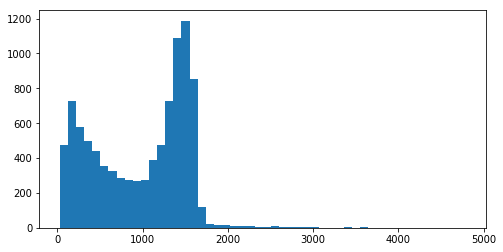

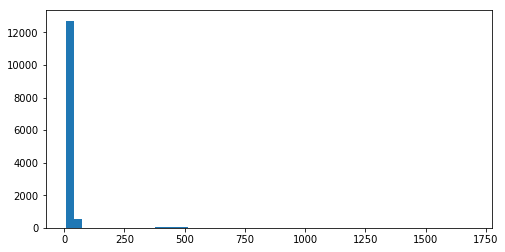

In [13]:
num_outliers = 0
two_std = np.mean(input_train["x_lengths"]) + 2*np.std(input_train["x_lengths"])
for x_length in input_train["x_lengths"]:
    num_outliers += 1 if x_length > max_length else 0

# Display train data stats
plt.figure(figsize=(8, 4))
plt.hist(input_train["x_lengths"], bins=50)
print("Largest train x length: {:d} frames".format(np.max(input_train["x_lengths"])))
print("2 std deviations (95%): {:d} frames".format(int(round(two_std))))
print("Outliers above max_length={:d}: {:.3f} %".format(max_length,
                                                        num_outliers/len(input_train["x_lengths"])*100))

# Display test data stats
plt.figure(figsize=(8, 4))
plt.hist(input_test["x_lengths"], bins=50)
print()

In [14]:
# Truncate/segment and limit dimensionality
def limit_dimensionality(x, dim_frame_feats=13):
    for i, seq in enumerate(x):
        x[i] = seq[:, :dim_frame_feats]


def truncate_segments(segment_data, max_length):
    x, x_lengths, keys, speakers = (segment_data["x"], segment_data["x_lengths"],
                                    segment_data["keys"], segment_data["speakers"])
    x_truncated = []
    x_lengths_truncated = []
    for i, seq in enumerate(x):
        x_truncated.append(seq[:max_length, :])
        x_lengths_truncated.append(min(x_lengths[i], max_length))
    return {"keys": np.asarray(keys),
            "x": np.asarray(x_truncated),
            "x_lengths": np.asarray(x_lengths_truncated),
            "speakers": np.asarray(speakers)}

def sequential_split_segments(segment_data, split_length):
    x, x_lengths, keys, speakers = (segment_data["x"], segment_data["x_lengths"],
                                    segment_data["keys"], segment_data["speakers"])
    x_split = []
    x_lengths_split = []
    keys_split = []
    speakers_split = []
    for i, seq in enumerate(x):
        for j in range(int(np.ceil(x_lengths[i]/split_length))):
            seg_length = min(x_lengths[i] - j*split_length, split_length)
            x_split.append(seq[j*split_length:j*split_length+seg_length, :])
            x_lengths_split.append(seg_length)
            keys_split.append("{}_split_{}".format(keys[i], j))
            speakers_split.append(speakers[i])
    return {"keys": np.asarray(keys_split),
            "x": np.asarray(x_split),
            "x_lengths": np.asarray(x_lengths_split),
            "speakers": np.asarray(speakers_split)}


limit_dimensionality(input_train["x"], dim_input_feats)
limit_dimensionality(input_test["x"], dim_input_feats)
limit_dimensionality(output_train["x"], dim_output_feats)
limit_dimensionality(output_test["x"], dim_output_feats)

input_train_truncated = truncate_segments(input_train, max_length)
input_test_truncated = truncate_segments(input_test, max_length)
output_train_truncated = truncate_segments(output_train, max_length)
output_test_truncated = truncate_segments(output_test, max_length)
                        
print("Num train segments before split", len(input_train["x"]))
input_train_split = sequential_split_segments(input_train, split_length)
input_test_split = sequential_split_segments(input_test, split_length)
output_train_split = sequential_split_segments(output_train, split_length)
output_test_split = sequential_split_segments(output_test, split_length)
print("Num train segments after split:", len(input_train_split["x"]))

# Get split train speaker ids
train_split_speaker_ids = []
for speaker in input_train_split["speakers"]:
    train_split_speaker_ids.append(speaker_to_id[speaker])
train_split_speaker_ids = np.array(train_split_speaker_ids, dtype=NP_INT_DTYPE)
# Get split test speaker ids
test_split_speaker_ids = []
for speaker in input_test_split["speakers"]:
    test_split_speaker_ids.append(speaker_to_id[speaker])
test_split_speaker_ids = np.array(test_split_speaker_ids, dtype=NP_INT_DTYPE)

Num train segments before split 9474
Num train segments after split: 23272


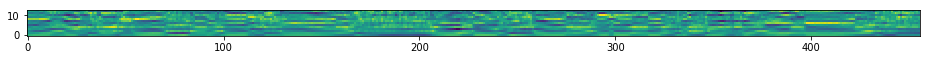

In [15]:
plt.figure(figsize=(16, 6))
plt.imshow(input_train_split["x"][8000].T, origin="bottom")

### Many-to-many sequence-to-sequence model with frame-level latent transformation (autoencoder)

In [16]:
# TODO(rpeloff): should rename this to `def build_the_thing_with_to_many_words(...)`
def build_multi_layer_many_to_many_with_latent(
        x_input, x_lengths, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
        rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None, dim_output_feats=None):
    """Build a multi-layer many-to-many sequence-to-sequence model with per-frame latent layers.
    
    Note: The decoders output is processed by a linear transformation such that the final
    output dimensionality matches that of the input `x_input`. 
    
    TODO(rpeloff): function doc
    
    `decoder_conditioning`: 
        Optionally condition the decoder on the concatenation of the latent representation and this tensor.
    """
    max_length = tf.math.reduce_max(x_lengths)  # compute maximum along the lengths tensor
    x_tensor = tf.convert_to_tensor(x_input)
    dim_features = x_tensor.get_shape().as_list()[-1]  # get input features dimensionality
    if dim_output_feats is None:
        dim_output_feats = dim_features

    # Multi-layer RNN encoder
    # -----------------------
    encoder_output, encoder_states = rnn.build_multi_layer_rnn(
        x_tensor, x_lengths, encoder_hidden_units, rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_encoder")
    
    # Latent transformation
    # ---------------------
    encoder_output_flattened = tf.reshape(encoder_output, [-1, encoder_hidden_units[-1]])
    latent_output = latent_transform(encoder_output_flattened, **latent_kwargs)
    latent_decoder_output = latent_output["y"]  # latent reconstruction output
    
    dim_decoder_output = latent_decoder_output.get_shape().as_list()[-1]  # latent decoded feature dimensionality
    latent_decoder_output = tf.reshape(latent_decoder_output, [-1, max_length, dim_decoder_output])  # reshaped (n_data, n_padded_frames, dim_decoder_feats)
    
    # Additional decoder conditioning
    # -------------------------------
    if decoder_conditioning is not None:
        dim_conditioning_tensor = decoder_conditioning.get_shape().as_list()[-1]
        tiled_conditioning = tf.reshape(  # tile conditioning tensor to max_length frames 
            tf.tile(decoder_conditioning, [1, max_length]), [-1, max_length, dim_conditioning_tensor])
        # Concatenate latent decoder outpout and frame-level conditioning tensor -> (n_data, n_padded_frames, dim_decoder_feats + dim_conditioning_feats) 
        rnn_decoder_input = tf.concat([latent_decoder_output, tiled_conditioning], axis=-1)
    else:
        rnn_decoder_input = latent_decoder_output
        
    # Multi-layer RNN decoder
    # -----------------------
    decoder_output, decoder_states = rnn.build_multi_layer_rnn(
        rnn_decoder_input, x_lengths, decoder_hidden_units,
        rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_decoder")
    
    # Final linear transformation
    # ---------------------------
    with tf.variable_scope("rnn_decoder/linear_output"):
        mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))  # get zero mask from padding
        decoder_output = tf.reshape(decoder_output, [-1, decoder_hidden_units[-1]])
        decoder_output = tf.keras.layers.Dense(units=dim_output_feats)(decoder_output)
        decoder_output = tf.reshape(decoder_output, [-1, max_length, dim_output_feats])
        decoder_output *= tf.expand_dims(mask, -1)  # make sure that output is zero where input was padded (since the linear transformation adds the bias variable to the zero-padding)

    return {
        "encoder_output": encoder_output,
        "latent_output": latent_output, 
        "decoder_output": decoder_output,
        "mask": mask,
        "max_length": max_length}


### Plotting encodings and reconstructions

In [17]:
def plot_latent_reconstruction(x_input, z_latent, y_recon, x_lengths=None, z_aux_dicts=None, plot_indices=None, figsize=(12, 8), plot_vertical=False):
    n_plots = 3 if z_aux_dicts is None else 3 + len(z_aux_dicts)
    if plot_vertical:
        n_vert = n_plots
        n_hor = 1
    else:
        n_vert = 1
        n_hor = n_plots
    plot_indices = range(min(len(x_input), 10)) if plot_indices is None else plot_indices
    for count, i in enumerate(plot_indices):
        plt.figure(figsize=figsize)
        # Plot original input
        plt.subplot(n_vert, n_hor, 1)
        if count == 0:
            plt.title("Input segment")
        x_input_i = x_input[i][:x_lengths[i]] if x_lengths is not None else x_input[i]
        plt.imshow(x_input_i.T)
        plt.axis("off")
        # Plot latent encoding
        plt.subplot(n_vert, n_hor, 2)
        if count == 0:
            plt.title("Latent encoding")
        z_latent_i = z_latent[i][:x_lengths[i]] if x_lengths is not None else z_latent[i]
        plt.imshow(z_latent_i.T)
        plt.axis("off")
        # Plot reconstruction (without padding)
        plt.subplot(n_vert, n_hor, 3)
        if count == 0:
            plt.title("Reconstructed segment")
        y_output_i = y_recon[i][:x_lengths[i]] if x_lengths is not None else y_recon[i]
        plt.imshow(y_output_i.T)
        plt.axis("off")
        if z_aux_dicts is not None:
            for j, (aux_key, z_aux) in enumerate(z_aux_dicts.items()):
                # Plot auxiliary encoding (without padding)
                plt.subplot(n_vert, n_hor, 4+j)
                if count == 0:
                    plt.title("Auxiliary encoding: {}".format(aux_key))
                z_aux_i = z_aux[i][:x_lengths[i]] if x_lengths is not None else z_aux[i]
                plt.imshow(z_aux_i.T)
                plt.axis("off")

### Embed train and test data

In [18]:
def get_save_dir(
        output_dir, item_name, language, input_feats, output_feats,
        seq_type, split_segments, max_length, target_speaker_id=None):
    save_dir =  os.path.join(
        output_dir,
        item_name,
        language,
        "{}-{}".format(input_feats, output_feats),
        seq_type,
        "{}_{}".format("split" if split_segments else "trunc", max_length),
        "no_speaker_cond" if target_speaker_id is None else "speaker_{}".format(target_speaker_id))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    return save_dir


def embed_and_save(
        segment_data, model_file, x_input, x_lengths, latent_encoding, decoder_output,
        aux_encoding_dict=None, speaker_id=None, output_dir="embedded", batch_size=1, shuffle=False,
        config=None, additional_feed=None, target_speaker_id=None):

    encoded_dict = {}
    decoded_dict = {}
    if aux_encoding_dict is not None:
        aux_dicts = {aux_key: {} for aux_key, _ in aux_encoding_dict.items()}

    embed_iterator = batching.BucketRNNBatcher(
        segment_data["x"], segment_data["keys"],
        batch_size=batch_size, n_buckets=50,  # many buckets to increase speed
        shuffle_first_epoch=shuffle, shuffle_every_epoch=False,
        small_final_batch=True)

    saver = tf.train.Saver()
    with tf.Session(config=config) as session:
        saver.restore(session, model_file)
        for batch, batch_lengths in tqdm_notebook(embed_iterator):
            x_input_np = batch[0]
            batch_keys = batch[1]
            x_lengths_np = batch_lengths[0]
            feed_dict = {x_input: x_input_np, x_lengths: x_lengths_np}
            if additional_feed is not None:
                feed_dict.update(additional_feed)
            if target_speaker_id is not None:
                feed_dict[speaker_id] = np.array([target_speaker_id]*np.shape(x_input_np)[0])
            z_encoding_np = session.run(latent_encoding,
                                        feed_dict=feed_dict)
            y_decoded_np = session.run(decoder_output,
                                       feed_dict=feed_dict)
            z_dim_feats = np.shape(z_encoding_np)[-1]
            y_dim_feats = np.shape(y_decoded_np)[-1]
            for z_enc, y_dec, length, key in zip(z_encoding_np, y_decoded_np,
                                                 x_lengths_np, batch_keys):
                z_enc_unpad = np.zeros((length, z_dim_feats), dtype=NP_FLOAT_DTYPE)
                y_enc_unpad = np.zeros((length, y_dim_feats), dtype=NP_FLOAT_DTYPE)
                z_enc_unpad = z_enc[:length, :]
                y_enc_unpad = y_dec[:length, :]
                encoded_dict[key] = z_enc_unpad
                decoded_dict[key] = y_enc_unpad
            if aux_encoding_dict is not None:  # eval and save auxillary encodings
                z_aux_dicts_np = {}
                for aux_key, z_auxiliary in aux_encoding_dict.items():
                    z_auxiliary_np = session.run(z_auxiliary,
                                                 feed_dict=feed_dict)
                    z_aux_dicts_np[aux_key] = z_auxiliary_np
                    z_aux_dim_feats = np.shape(z_auxiliary_np)[-1]
                    for z_aux_enc, length, key in zip(z_auxiliary_np, x_lengths_np, batch_keys):                            
                        z_aux_unpad = np.zeros((length, z_aux_dim_feats), dtype=NP_FLOAT_DTYPE)
                        z_aux_unpad = z_aux_enc[:length, :]
                        aux_dicts[aux_key][key] = z_aux_unpad

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    np.savez_compressed(os.path.join(output_dir, "output_encoded.npz"), **encoded_dict)
    np.savez_compressed(os.path.join(output_dir, "output_decoded.npz"), **decoded_dict)

    fig = plt.figure(figsize=(16,6))
    ex_key = list(encoded_dict.keys())[-1]
    plt.imshow(encoded_dict[ex_key].T, origin="bottom")
    plt.title("Encoded sequence")
    fig.savefig(os.path.join(output_dir, "encoded_example.pdf"), bbox_inches='tight')

    fig = plt.figure(figsize=(16,6))
    plt.imshow(decoded_dict[ex_key].T, origin="bottom")
    plt.title("Decoded sequence")
    fig.savefig(os.path.join(output_dir, "decoded_example.pdf"), bbox_inches='tight')
    
    del encoded_dict, decoded_dict
    
    if aux_encoding_dict is not None:
        for dict_key, aux_dict in aux_dicts.items():
            np.savez_compressed(os.path.join(output_dir, "output_auxiliary_{}.npz".format(dict_key)), **aux_dict)

            fig = plt.figure(figsize=(16,6))
            plt.imshow(aux_dict[ex_key].T, origin="bottom")
            plt.title("Auxiliary encoded sequence: {}".format(dict_key))
            fig.savefig(os.path.join(output_dir, "auxiliary_{}_example.pdf".format(dict_key)), bbox_inches='tight')

        return x_input_np, z_encoding_np, y_decoded_np, x_lengths_np, z_aux_dicts_np  # example batch
    else:
        return x_input_np, z_encoding_np, y_decoded_np, x_lengths_np  # example batch

### Train seq2seq with vanilla autoencoder bottleneck (no speaker conditional)

In [19]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_autoencoder
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 128,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"

# Many-to-many autoencoder model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=None, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

z_encoding_tf = tf.reshape(latent_dict["z"], [-1, max_length_tf, latent_kwargs["z_units"]])

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# -------------------
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x_output_tf - decoder_output_tf), -1), -1) / tf.reduce_sum(mask_tf, 1))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, False, max_length)
intermediate_model_file = os.path.join(model_dir, "many_to_many_ae.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_ae.ckpt")


In [20]:
vis.show_tf_graph(tf.get_default_graph())

In [21]:
np.random.seed(1)

# Train on truncated sequences
train_batch_iterator = batching.BucketRNNBatcher(
    input_train_truncated["x"], output_train_truncated["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.BucketRNNBatcher(
    input_test["x"], output_test["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False)

In [22]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_output_tf, x_lengths_tf], loss,
    val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 11:45:38.619896
Epoch 0:
41.594 sec, train loss: 0.6357866, val loss: 0.4281492 *
Epoch 1:
39.660 sec, train loss: 0.15260936, val loss: 0.16345549 *
Epoch 2:
39.806 sec, train loss: 0.021255335, val loss: 0.11851471 *
Epoch 3:
40.210 sec, train loss: 0.010997562, val loss: 0.10894482 *
Epoch 4:
40.114 sec, train loss: 0.008306337, val loss: 0.104064785 *
Epoch 5:
39.976 sec, train loss: 0.007072539, val loss: 0.10199306 *
Epoch 6:
40.178 sec, train loss: 0.0064280652, val loss: 0.1000705 *
Epoch 7:
40.052 sec, train loss: 0.005377482, val loss: 0.0988373 *
Epoch 8:
39.991 sec, train loss: 0.0049273027, val loss: 0.09853509 *
Epoch 9:
40.211 sec, train loss: 0.004747503, val loss: 0.0970215 *
Epoch 10:
40.196 sec, train loss: 0.0046910453, val loss: 0.09553684 *
Epoch 11:
40.176 sec, train loss: 0.00379194, val loss: 0.09500735 *
Epoch 12:
39.772 sec, train loss: 0.004133548, val loss: 0.09388466 *
Epoch 13:
40.171 sec, train loss: 0.0033361376, val loss: 0.093040876 *
Epoch

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_ae.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_ae.ckpt


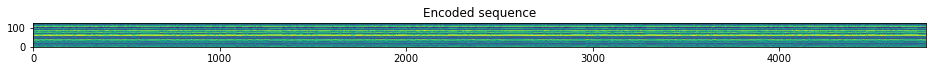

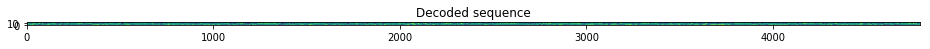

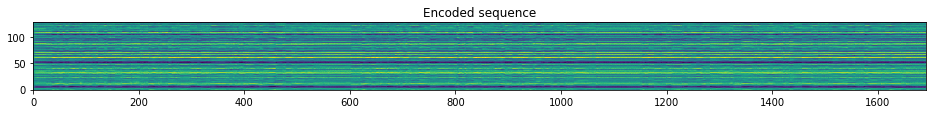

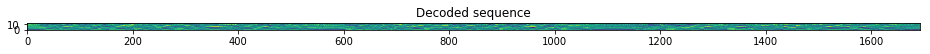

In [23]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, False, max_length)

embed_and_save(
    input_train, model_file, x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=None, output_dir=os.path.join(embed_dir, "many_to_many_ae", "train"),
    batch_size=100, shuffle=False, config=config, additional_feed=None)

ex_batch = embed_and_save(
    input_test, model_file, x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=None, output_dir=os.path.join(embed_dir, "many_to_many_ae", "test"),
    batch_size=100, shuffle=False, config=config, additional_feed=None)

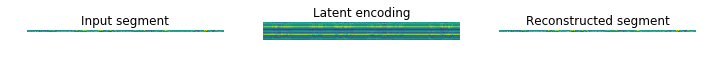

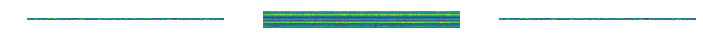

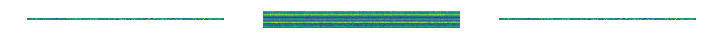

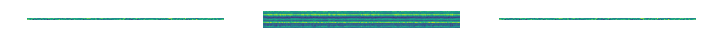

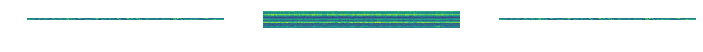

In [24]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(5), figsize=(12, 16))

### Train seq2seq with vanilla autoencoder bottleneck (with speaker conditional)

In [25]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
n_speakers = max(speaker_to_id.values()) + 1
dim_speaker_embedding = 100

encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_autoencoder
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 128,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"

# Many-to-many autoencoder model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_output")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")
speaker_id_tf = tf.placeholder(TF_INT_DTYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable("embed",
                                        [n_speakers, dim_speaker_embedding],
                                        dtype=TF_FLOAT_DTYPE)
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id_tf)

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=embedding_lookup, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

z_encoding_tf = tf.reshape(latent_dict["z"], [-1, max_length_tf, latent_kwargs["z_units"]])

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# -------------------
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x_output_tf - decoder_output_tf), -1), -1) / tf.reduce_sum(mask_tf, 1))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, False, max_length, target_speaker_id="cond")
intermediate_model_file = os.path.join(model_dir, "many_to_many_ae_speaker_cond.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_ae_speaker_cond.ckpt")


In [26]:
vis.show_tf_graph(tf.get_default_graph())

In [27]:
np.random.seed(1)

# Train on truncated sequences
train_batch_iterator = batching.BucketRNNBatcher(
    input_train_truncated["x"], output_train_truncated["x"], train_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.BucketRNNBatcher(
    input_test["x"], output_test["x"], test_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False)

In [28]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_output_tf, speaker_id_tf, x_lengths_tf], loss,
    val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 12:02:56.830635
Epoch 0:
41.124 sec, train loss: 0.647013, val loss: 0.43040586 *
Epoch 1:
40.836 sec, train loss: 0.13889599, val loss: 0.16768843 *
Epoch 2:
40.746 sec, train loss: 0.020637518, val loss: 0.1285475 *
Epoch 3:
40.876 sec, train loss: 0.010868551, val loss: 0.119244196 *
Epoch 4:
40.849 sec, train loss: 0.008567805, val loss: 0.11500242 *
Epoch 5:
40.519 sec, train loss: 0.007315208, val loss: 0.1128517 *
Epoch 6:
40.742 sec, train loss: 0.006171109, val loss: 0.11130822 *
Epoch 7:
40.521 sec, train loss: 0.005676651, val loss: 0.11085932 *
Epoch 8:
40.559 sec, train loss: 0.0052386005, val loss: 0.10829049 *
Epoch 9:
40.786 sec, train loss: 0.004762585, val loss: 0.10736408 *
Epoch 10:
40.551 sec, train loss: 0.0044851964, val loss: 0.105989054 *
Epoch 11:
40.633 sec, train loss: 0.0038825131, val loss: 0.105547525 *
Epoch 12:
40.552 sec, train loss: 0.004117235, val loss: 0.10394202 *
Epoch 13:
40.745 sec, train loss: 0.0035861018, val loss: 0.10294172 *
Ep

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_ae_speaker_cond.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_ae_speaker_cond.ckpt


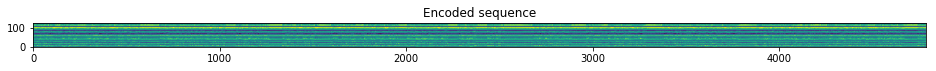

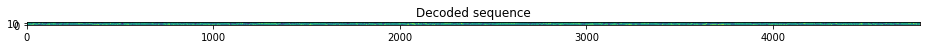

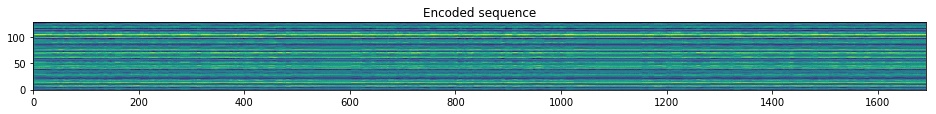

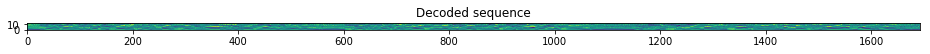

In [29]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

target_speaker_id = speaker_to_id["V001"]  #  "V001" or "V002" for target speakers
embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, False, max_length, id_to_speaker[target_speaker_id])

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_ae", "train"),
    batch_size=100, shuffle=False, config=config,
    additional_feed=None, target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_test, model_file, x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_ae", "test"),
    batch_size=100, shuffle=False, config=config, additional_feed=None, target_speaker_id=target_speaker_id)

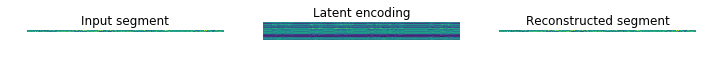

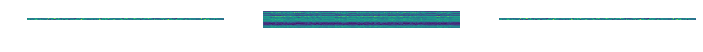

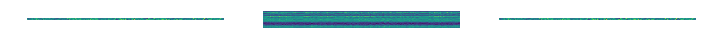

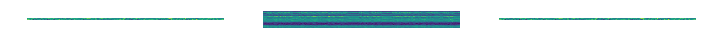

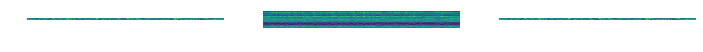

In [30]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(5), figsize=(12, 16))

### Train seq2seq with VAE bottleneck (without speaker conditional)

In [31]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_vae
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 128,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"

# Many-to-many VAE bottlneck model
# --------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=None, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

z_mean_tf = latent_dict["z_mean"], 
z_log_sigma_sq_tf = latent_dict["z_log_sigma_sq"]
z_encoding_tf = tf.reshape(latent_dict["z"], [-1, max_length_tf, latent_kwargs["z_units"]])  # reshape to frame-level

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# Gaussian VAE loss
# -----------------
# sigma_sq = 0.001  # smaller values: care more about reconstruction
# loss = ae.vae_loss_gaussian(x_output_tf, decoder_output, sigma_sq, z_mean, z_log_sigma_sq)

# Bernoulli VAE loss
# ------------------
# y = tf.nn.sigmoid(decoder_output)  # use with the Bernoulli loss
# loss = vae_loss_bernoulli(x_output_tf, y, z_mean, z_log_sigma_sq)

# Fixed Gaussian VAE reconstruction loss
# --------------------------------------
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
sigma_sq = 0.0001  #0.001  # smaller values care more about reconstruction
reconstruction_loss = (
    1./(2*sigma_sq)*(
        tf.reduce_mean(
            tf.reduce_sum(
                tf.reduce_mean(
                    tf.square(x_output_tf - decoder_output_tf),
                    -1),
                -1) / tf.reduce_sum(mask_tf, 1))))

regularisation_loss = -0.5*tf.reduce_sum(1 + z_log_sigma_sq_tf - tf.square(z_mean_tf) - tf.exp(z_log_sigma_sq_tf), 1)
loss = reconstruction_loss + tf.reduce_mean(regularisation_loss)

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, False, max_length)
intermediate_model_file = os.path.join(model_dir, "many_to_many_vae.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_vae.ckpt")


In [32]:
vis.show_tf_graph(tf.get_default_graph())

In [33]:
np.random.seed(1)

# Train on truncated sequences
train_batch_iterator = batching.BucketRNNBatcher(
    input_train_truncated["x"], output_train_truncated["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.BucketRNNBatcher(
    input_test["x"], output_test["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False)

In [34]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_output_tf, x_lengths_tf], loss,
    val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 12:20:21.565860
Epoch 0:
41.882 sec, train loss: 5861.324, val loss: 4814.7764 *
Epoch 1:
41.382 sec, train loss: 4965.9673, val loss: 4718.8936 *
Epoch 2:
41.429 sec, train loss: 4863.3833, val loss: 4666.1797 *
Epoch 3:
41.518 sec, train loss: 4812.7163, val loss: 4631.471 *
Epoch 4:
41.445 sec, train loss: 4779.643, val loss: 4610.2017 *
Epoch 5:
41.578 sec, train loss: 4756.4414, val loss: 4589.921 *
Epoch 6:
41.419 sec, train loss: 4738.1245, val loss: 4577.7856 *
Epoch 7:
41.327 sec, train loss: 4722.01, val loss: 4546.599 *
Epoch 8:
41.354 sec, train loss: 4709.4893, val loss: 4534.461 *
Epoch 9:
41.263 sec, train loss: 4697.2134, val loss: 4512.845 *
Epoch 10:
40.915 sec, train loss: 4689.348, val loss: 4515.73
Epoch 11:
41.249 sec, train loss: 4680.0474, val loss: 4501.721 *
Epoch 12:
41.501 sec, train loss: 4672.7207, val loss: 4486.7207 *
Epoch 13:
41.353 sec, train loss: 4663.276, val loss: 4471.033 *
Epoch 14:
41.443 sec, train loss: 4657.1694, val loss: 4462.76

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vae.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vae.ckpt


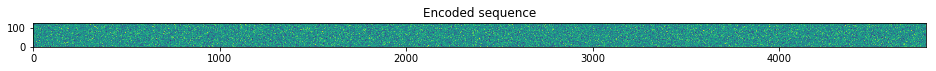

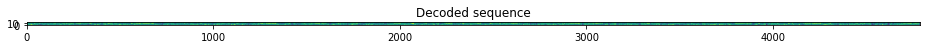

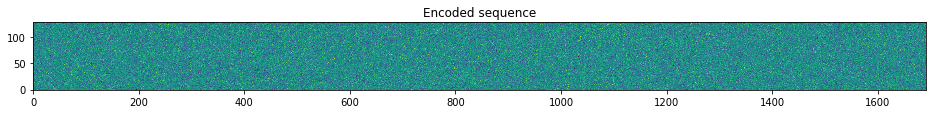

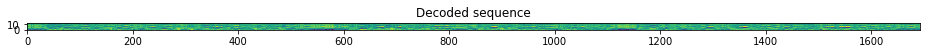

In [35]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, False, max_length)

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_vae", "train"),
    batch_size=100, shuffle=False, config=config,
    additional_feed=None, target_speaker_id=None)

ex_batch = embed_and_save(
    input_test, model_file, x_input_tf, x_lengths_tf, z_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None, speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_vae", "test"),
    batch_size=100, shuffle=False, config=config, additional_feed=None, target_speaker_id=None)

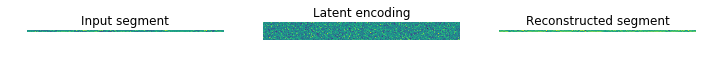

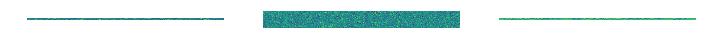

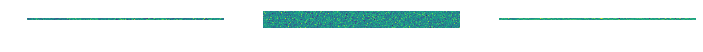

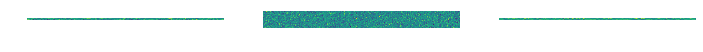

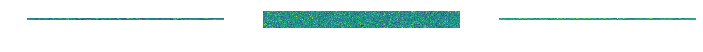

In [36]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(5), figsize=(12, 16))

### Train seq2seq with VQ-VAE bottleneck (without speaker conditional)

In [37]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 150
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_vq_vae
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 100,  # dimension of category embeddings
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu",
    "K": 128  # 128 discrete categories
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"

# Many-to-many VQ-VAE bottleneck model
# ------------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=None, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

z_embed_tf = latent_dict["z_embed"]  # sequence encoding prior to quantisation (auxiliary)
q_embeds_tf = latent_dict["q_embeds"]  # vector quantised embedding space [K, z_units]
k_q_indices_tf = latent_dict["k_q_indices"]  # vector quantised sequence encoding indices
z_quantised_tf = latent_dict["z_quantised"]  # vector quantised sequence encoding vectors

z_cont_encoding_tf = tf.reshape(z_embed_tf, [-1, max_length_tf, latent_kwargs["z_units"]])
z_onehot_encoding_tf = tf.one_hot(tf.reshape(k_q_indices_tf, [-1, max_length_tf]), latent_kwargs["K"], axis=-1)
z_vq_encoding_tf = tf.reshape(z_quantised_tf, [-1, max_length_tf, latent_kwargs["z_units"]])

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# VQ-VAE Gaussian reconstruction loss
# -----------------------------------
sigma_sq = 0.00001  # smaller values: care more about reconstruction
beta = 0.25
loss, recon_loss, vq_loss, commit_loss, optimiser = ae.vq_vae_loss(
    x_output_tf, z_embed_tf, z_quantised_tf, q_embeds_tf, decoder_output_tf,
    learning_rate=learning_rate, sigma_sq=sigma_sq, beta=beta)
reconstruction_loss = tf.losses.mean_squared_error(x_output_tf, decoder_output_tf)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, True, split_length)
intermediate_model_file = os.path.join(model_dir, "many_to_many_vq_vae.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_vq_vae.ckpt")


In [38]:
vis.show_tf_graph(tf.get_default_graph())

In [39]:
np.random.seed(1)

# Train on split sequences (VQ-VAE is more memory intensive -- to be explained?)
train_batch_iterator = batching.BucketRNNBatcher(
    input_train_split["x"], output_train_split["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.BucketRNNBatcher(
    input_test_split["x"], output_test_split["x"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False)

In [40]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, [loss, recon_loss, vq_loss, reconstruction_loss], 
    train_batch_iterator, [x_input_tf, x_output_tf, x_lengths_tf],
    [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 12:38:03.942750
Epoch 0:
127.449 sec, train loss: [2.6273439e+04 2.6226930e+04 3.7204952e+01 5.2453864e-01], val loss: [1.6918646e+04 3.3766469e-01] *
Epoch 1:
126.853 sec, train loss: [2.1620803e+04 2.1561012e+04 4.7839565e+01 4.3122026e-01], val loss: [1.6058474e+04 3.2043132e-01] *
Epoch 2:
126.864 sec, train loss: [2.0803578e+04 2.0745084e+04 4.6788052e+01 4.1490173e-01], val loss: [1.5526698e+04 3.0978993e-01] *
Epoch 3:
127.087 sec, train loss: [2.0130438e+04 2.0072604e+04 4.6270439e+01 4.0145200e-01], val loss: [1.5090200e+04 3.0105808e-01] *
Epoch 4:
126.943 sec, train loss: [1.9221711e+04 1.9165447e+04 4.5012421e+01 3.8330880e-01], val loss: [1.4561372e+04 2.9049194e-01] *
Epoch 5:
126.820 sec, train loss: [1.8490799e+04 1.8435793e+04 4.4002045e+01 3.6871585e-01], val loss: [1.4206328e+04 2.8339735e-01] *
Epoch 6:
126.975 sec, train loss: [1.7847027e+04 1.7793072e+04 4.3161480e+01 3.5586160e-01], val loss: [1.3756429e+04 2.7440950e-01] *
Epoch 7:
127.330 sec, train 

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vq_vae.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vq_vae.ckpt


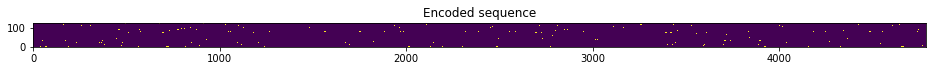

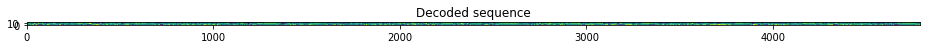

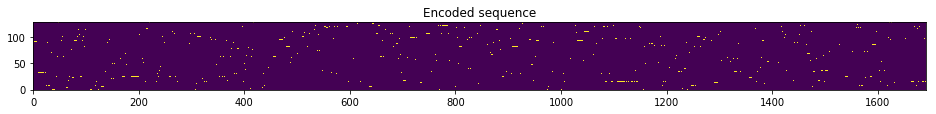

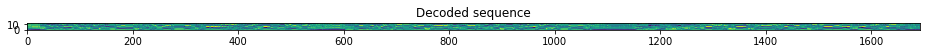

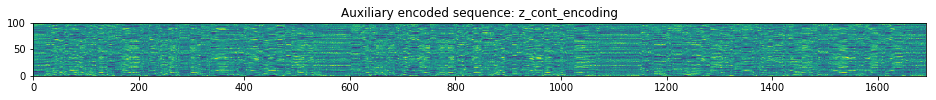

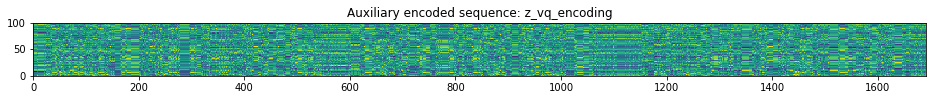

In [41]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, True, split_length)

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_onehot_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,  #{"z_cont_encoding": z_cont_encoding_tf, "z_vq_encoding": z_vq_encoding_tf},
    speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_vq_vae", "train"),
    batch_size=20, shuffle=False, config=config,
    additional_feed=None, target_speaker_id=None)

ex_batch = embed_and_save(
    input_test, model_file,
    x_input_tf, x_lengths_tf, z_onehot_encoding_tf, decoder_output_tf,
    aux_encoding_dict={"z_cont_encoding": z_cont_encoding_tf, "z_vq_encoding": z_vq_encoding_tf},
    speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_vq_vae", "test"),
    batch_size=20, shuffle=False, config=config, additional_feed=None, target_speaker_id=None)

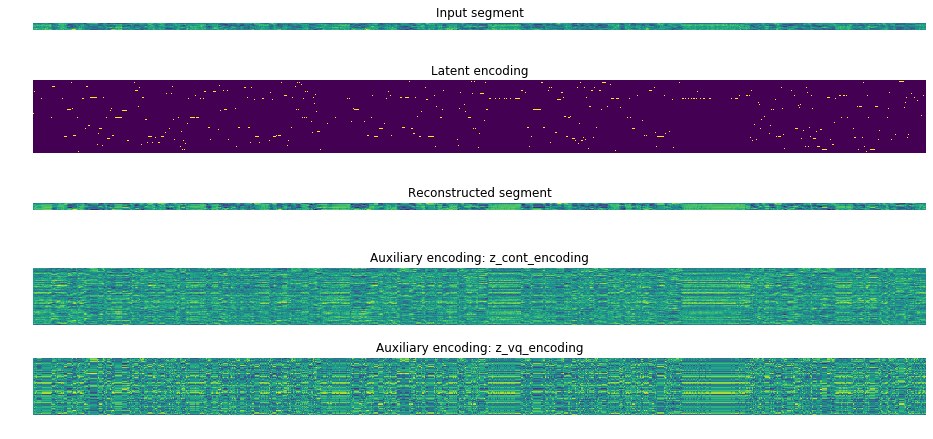

In [42]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(1), figsize=(16, 8), plot_vertical=True)

### Train seq2seq with VQ-VAE bottleneck (with speaker conditional)

In [43]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 150
n_buckets = 3

# Model parameters
# ----------------
n_speakers = max(speaker_to_id.values()) + 1
dim_speaker_embedding = 100

encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_vq_vae
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 100,  # dimension of category embeddings
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu",
    "K": 128  # 128 discrete categories
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"

# Many-to-many VQ-VAE bottleneck model
# ------------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")
speaker_id_tf = tf.placeholder(TF_INT_DTYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable("embed",
                                        [n_speakers, dim_speaker_embedding],
                                        dtype=TF_FLOAT_DTYPE)
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id_tf)

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=embedding_lookup, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

z_embed_tf = latent_dict["z_embed"]  # sequence encoding prior to quantisation (auxiliary)
q_embeds_tf = latent_dict["q_embeds"]  # vector quantised embedding space [K, z_units]
k_q_indices_tf = latent_dict["k_q_indices"]  # vector quantised sequence encoding indices
z_quantised_tf = latent_dict["z_quantised"]  # vector quantised sequence encoding vectors

z_cont_encoding_tf = tf.reshape(z_embed_tf, [-1, max_length_tf, latent_kwargs["z_units"]])
z_onehot_encoding_tf = tf.one_hot(tf.reshape(k_q_indices_tf, [-1, max_length_tf]), latent_kwargs["K"], axis=-1)
z_vq_encoding_tf = tf.reshape(z_quantised_tf, [-1, max_length_tf, latent_kwargs["z_units"]])

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# VQ-VAE Gaussian reconstruction loss
# -----------------------------------
sigma_sq = 0.00001  # smaller values: care more about reconstruction
beta = 0.25
loss, recon_loss, vq_loss, commit_loss, optimiser = ae.vq_vae_loss(
    x_output_tf, z_embed_tf, z_quantised_tf, q_embeds_tf, decoder_output_tf,
    learning_rate=learning_rate, sigma_sq=sigma_sq, beta=beta)
reconstruction_loss = tf.losses.mean_squared_error(x_output_tf, decoder_output_tf)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, True, split_length, target_speaker_id="cond)

intermediate_model_file = os.path.join(model_dir, "many_to_many_vq_vae_speaker_cond.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_vq_vae_speaker_cond.ckpt")


In [44]:
vis.show_tf_graph(tf.get_default_graph())

In [45]:
np.random.seed(1)

# Train on split sequences (VQ-VAE is more memory intensive -- to be explained?)
train_batch_iterator = batching.BucketRNNBatcher(
    input_train_split["x"], output_train_split["x"], train_split_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.BucketRNNBatcher(
    input_test_split["x"], output_test_split["x"], test_split_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False)

In [46]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, [loss, recon_loss, vq_loss, reconstruction_loss], 
    train_batch_iterator, [x_input_tf, x_output_tf, speaker_id_tf, x_lengths_tf],
    [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 13:25:17.775743
Epoch 0:
126.446 sec, train loss: [2.5507154e+04 2.5464904e+04 3.3798534e+01 5.0929809e-01], val loss: [1.6352689e+04 3.2639387e-01] *
Epoch 1:
125.585 sec, train loss: [2.0268691e+04 2.0213324e+04 4.4293316e+01 4.0426651e-01], val loss: [1.5612317e+04 3.1155390e-01] *
Epoch 2:
125.730 sec, train loss: [1.9061838e+04 1.9007746e+04 4.3273071e+01 3.8015506e-01], val loss: [1.5118533e+04 3.0167979e-01] *
Epoch 3:
125.690 sec, train loss: [1.8121053e+04 1.8068477e+04 4.2064175e+01 3.6136958e-01], val loss: [1.4668974e+04 2.9270062e-01] *
Epoch 4:
125.925 sec, train loss: [1.7115822e+04 1.7065457e+04 4.0292591e+01 3.4130919e-01], val loss: [1.4184603e+04 2.8302851e-01] *
Epoch 5:
125.858 sec, train loss: [1.6498699e+04 1.6449949e+04 3.8996090e+01 3.2899916e-01], val loss: [1.3820133e+04 2.7575091e-01] *
Epoch 6:
125.840 sec, train loss: [1.5937030e+04 1.5889581e+04 3.7949348e+01 3.1779188e-01], val loss: [1.3446622e+04 2.6829413e-01] *
Epoch 7:
125.692 sec, train 

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vq_vae_speaker_cond.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/split_2000/no_speaker_cond/many_to_many_vq_vae_speaker_cond.ckpt


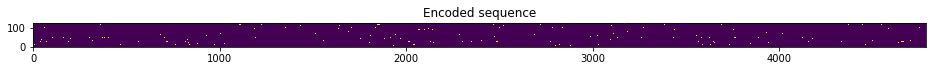

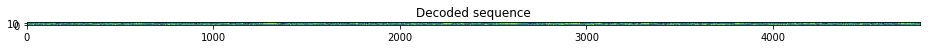

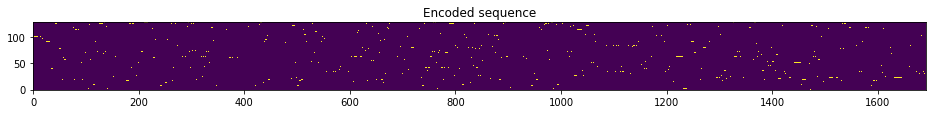

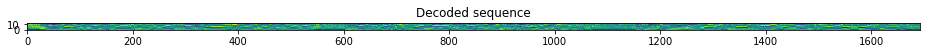

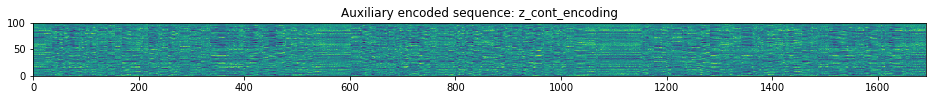

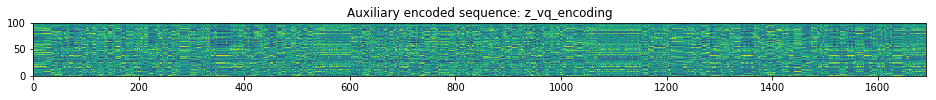

In [47]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

target_speaker_id = speaker_to_id["V001"]  #  "V001" or "V002" for target speakers
embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, True, split_length, id_to_speaker[target_speaker_id])

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_onehot_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,
    speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_vq_vae", "train"),
    batch_size=20, shuffle=False, config=config,
    additional_feed=None, target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_test, model_file,
    x_input_tf, x_lengths_tf, z_onehot_encoding_tf, decoder_output_tf,
    aux_encoding_dict={"z_cont_encoding": z_cont_encoding_tf, "z_vq_encoding": z_vq_encoding_tf},
    speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_vq_vae", "test"),
    batch_size=20, shuffle=False, config=config, additional_feed=None, target_speaker_id=target_speaker_id)

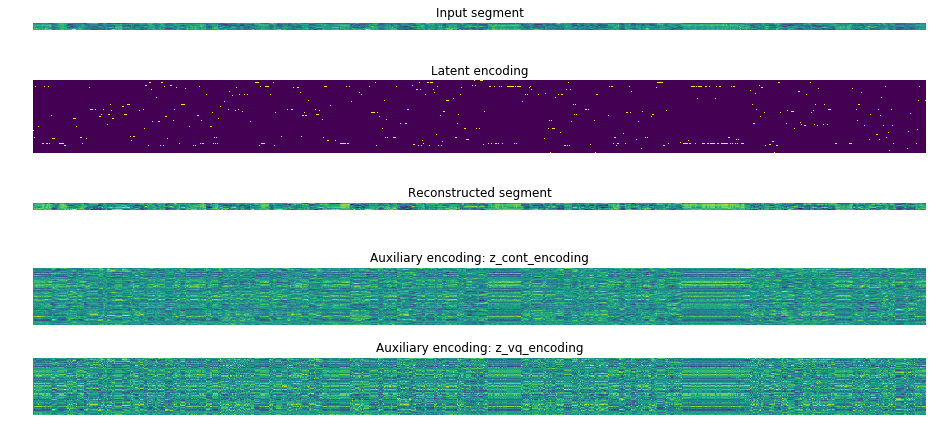

In [48]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(1), figsize=(16, 8), plot_vertical=True)

### Train seq2seq with CatVAE bottleneck (without speaker conditional)

In [19]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_cat_vae
K = 128  # 32
N = 1    # 4
latent_kwargs = {
    "encoder_hidden_units": [],
    "K": K,
    "N": N,
    "decoder_hidden_units": [],
    "activation": "relu"
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"


# Many-to-many CatVAE model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_output")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=None, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

softmax_logits_tf = latent_dict["softmax_logits"]  # class probabilities before categorical approximation 
log_logits_categorical_tf = latent_dict["log_logits_categorical"]  # log of class probabilities
z_categorical_tf = latent_dict["z_categorical"]  # gumbel-softmax categorical samples for class probabilities
tau_tf = latent_dict["tau"]
hard_discrete_handle_tf = latent_dict["hard_discrete_handle"]

z_cat_encoding_tf = tf.reshape(z_categorical_tf, [-1, max_length_tf, latent_kwargs["K"]*latent_kwargs["N"]])
# auxiliary ??

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# Temperature
tau_init = 1.
tau_min = 0.1  # 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits_tf*(log_logits_categorical_tf - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x_output_tf, decoder_output_tf) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x_output_tf, decoder_output_tf)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, False, max_length)
intermediate_model_file = os.path.join(model_dir, "many_to_many_cat_vae.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_cat_vae.ckpt")


In [20]:
vis.show_tf_graph(tf.get_default_graph())

In [21]:
np.random.seed(1)

# Train on truncated sequences
train_batch_iterator = batching.TemperatureRNNBatcher(
    input_train_truncated["x"], output_train_truncated["x"],
    batch_size=batch_size, n_buckets=n_buckets, temperatures=tau_list, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.TemperatureRNNBatcher(
    input_test["x"], output_test["x"],
    batch_size=batch_size, n_buckets=n_buckets, temperatures=[tau_min], shuffle_every_epoch=False)

In [22]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, [loss, reconstruction_loss, tau_tf], train_batch_iterator,
    [x_input_tf, x_output_tf, x_lengths_tf, x_lengths_tf, tau_tf],
    [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 16:31:04.506377
Epoch 0:
43.547 sec, train loss: [3.2939180e+04 6.5878224e-01 1.0000000e+00], val loss: [2.6322256e+04 5.2644354e-01] *
Epoch 1:
42.098 sec, train loss: [2.9929760e+04 5.9858769e-01 9.5263135e-01], val loss: [2.4637639e+04 4.9274608e-01] *
Epoch 2:
41.357 sec, train loss: [2.5732234e+04 5.1462376e-01 9.0526342e-01], val loss: [2.2551689e+04 4.5101878e-01] *
Epoch 3:
41.626 sec, train loss: [2.2654023e+04 4.5304966e-01 8.5789484e-01], val loss: [2.0964656e+04 4.1927180e-01] *
Epoch 4:
42.548 sec, train loss: [2.0030092e+04 4.0056565e-01 8.1052601e-01], val loss: [1.9840723e+04 3.9678958e-01] *
Epoch 5:
43.097 sec, train loss: [1.8304600e+04 3.6605313e-01 7.6315820e-01], val loss: [1.8845143e+04 3.7687546e-01] *
Epoch 6:
43.345 sec, train loss: [1.6898312e+04 3.3792579e-01 7.1578962e-01], val loss: [1.7994498e+04 3.5986066e-01] *
Epoch 7:
42.903 sec, train loss: [1.5940508e+04 3.1876817e-01 6.6842085e-01], val loss: [1.7318752e+04 3.4634432e-01] *
Epoch 8:
42.9

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/trunc_2000/no_speaker_cond/many_to_many_cat_vae.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/trunc_2000/no_speaker_cond/many_to_many_cat_vae.ckpt


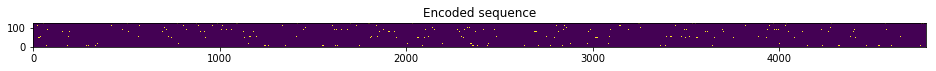

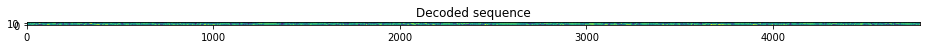

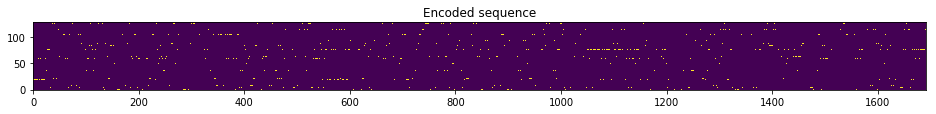

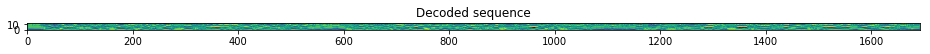

In [23]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

additional_feed = {tau_tf: tau_min, hard_discrete_handle_tf: True}

embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, False, max_length)

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_cat_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,
    speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_cat_vae", "train"),
    batch_size=100, shuffle=False, config=config,
    additional_feed=additional_feed, target_speaker_id=None)

ex_batch = embed_and_save(
    input_test, model_file,
    x_input_tf, x_lengths_tf, z_cat_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,
    speaker_id=None,
    output_dir=os.path.join(embed_dir, "many_to_many_cat_vae", "test"),
    batch_size=100, shuffle=False, config=config, additional_feed=additional_feed, target_speaker_id=None)

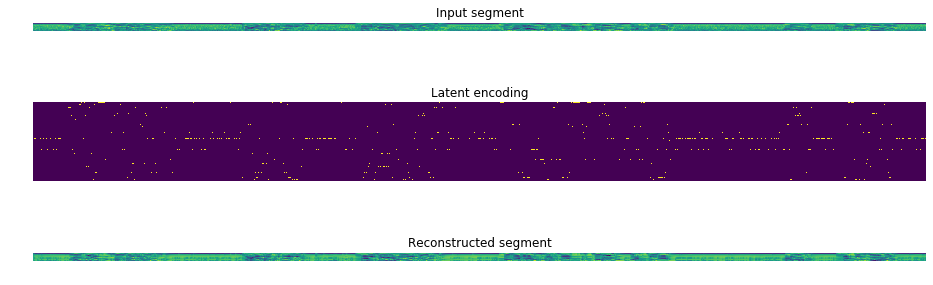

In [24]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(1), figsize=(16, 6), plot_vertical=True)

### Train seq2seq with CatVAE bottleneck (with speaker conditional)

In [25]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
n_speakers = max(speaker_to_id.values()) + 1
dim_speaker_embedding = 100

encoder_hidden_units = [100]
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_cat_vae
K = 128  # 32
N = 1    # 4
latent_kwargs = {
    "encoder_hidden_units": [],
    "K": K,
    "N": N,
    "decoder_hidden_units": [],
    "activation": "relu"
    }
rnn_type = "lstm"  # "lstm", "gru" or "rnn"


# Many-to-many CatVAE model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_output_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_output_feats], name="x_output")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")
_speaker_id_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="speaker_id_lengths")  #TODO(rpeloff): fix hack
speaker_id_tf = tf.placeholder(TF_INT_DTYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable("embed",
                                        [n_speakers, dim_speaker_embedding],
                                        dtype=TF_FLOAT_DTYPE)
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id_tf)

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units,
    latent_transform, latent_kwargs, rnn_cell=rnn_type, rnn_cell_kwargs=None,
    keep_prob=1., decoder_conditioning=embedding_lookup, dim_output_feats=dim_output_feats)

encoder_output_tf = network_dict["encoder_output"]
latent_dict = network_dict["latent_output"]
decoder_output_tf = network_dict["decoder_output"]
max_length_tf = network_dict["max_length"]
mask_tf = network_dict["mask"]

softmax_logits_tf = latent_dict["softmax_logits"]  # class probabilities before categorical approximation 
log_logits_categorical_tf = latent_dict["log_logits_categorical"]  # log of class probabilities
z_categorical_tf = latent_dict["z_categorical"]  # gumbel-softmax categorical samples for class probabilities
tau_tf = latent_dict["tau"]
hard_discrete_handle_tf = latent_dict["hard_discrete_handle"]

z_cat_encoding_tf = tf.reshape(z_categorical_tf, [-1, max_length_tf, latent_kwargs["K"]*latent_kwargs["N"]])
# auxiliary ??

decoder_output_tf *= tf.expand_dims(mask_tf, -1)  # doubly make sure that output is zero where input was padded

# Temperature
tau_init = 1.
tau_min = 0.1  # 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits_tf*(log_logits_categorical_tf - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x_output_tf, decoder_output_tf) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x_output_tf, decoder_output_tf)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
model_dir = get_save_dir(output_dir, "models", language, input_feats, output_feats,
                         seq_type, False, max_length, target_speaker_id="cond)
intermediate_model_file = os.path.join(model_dir, "many_to_many_cat_vae_speaker_cond.tmp.ckpt")
model_file = os.path.join(model_dir, "many_to_many_cat_vae_speaker_cond.ckpt")


In [26]:
vis.show_tf_graph(tf.get_default_graph())

In [27]:
np.random.seed(1)

# Train on truncated sequences
train_batch_iterator = batching.TemperatureRNNBatcher(
    input_train_truncated["x"], output_train_truncated["x"], train_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, temperatures=tau_list, shuffle_every_epoch=True)

# Validate on unsegmented sequences
val_batch_iterator = batching.TemperatureRNNBatcher(
    input_test["x"], output_test["x"], test_speaker_ids,
    batch_size=batch_size, n_buckets=n_buckets, temperatures=[tau_min], shuffle_every_epoch=False)

In [28]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, [loss, reconstruction_loss, tau_tf], train_batch_iterator,
    [x_input_tf, x_output_tf, speaker_id_tf, x_lengths_tf, x_lengths_tf, _speaker_id_lengths_tf, tau_tf],
    [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_file,
    config=config)

2019-02-14 16:46:57.716973
Epoch 0:
42.803 sec, train loss: [3.3267676e+04 6.6535211e-01 1.0000000e+00], val loss: [2.6433658e+04 5.2867121e-01] *
Epoch 1:
42.604 sec, train loss: [2.9734742e+04 5.9468693e-01 9.5263135e-01], val loss: [2.4369383e+04 4.8738089e-01] *
Epoch 2:
42.468 sec, train loss: [2.5212936e+04 5.0424045e-01 9.0526342e-01], val loss: [2.2340830e+04 4.4680345e-01] *
Epoch 3:
43.084 sec, train loss: [2.2012682e+04 4.4022569e-01 8.5789484e-01], val loss: [2.0840695e+04 4.1679513e-01] *
Epoch 4:
43.580 sec, train loss: [1.9295225e+04 3.8587219e-01 8.1052601e-01], val loss: [1.9497234e+04 3.8992208e-01] *
Epoch 5:
43.049 sec, train loss: [1.7190195e+04 3.4376806e-01 7.6315820e-01], val loss: [1.8321244e+04 3.6639929e-01] *
Epoch 6:
42.195 sec, train loss: [1.5544820e+04 3.1085864e-01 7.1578962e-01], val loss: [1.7356396e+04 3.4710035e-01] *
Epoch 7:
42.197 sec, train loss: [1.4362160e+04 2.8720438e-01 6.6842085e-01], val loss: [1.6533541e+04 3.3064163e-01] *
Epoch 8:
42.5

INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/trunc_2000/no_speaker_cond/many_to_many_cat_vae_speaker_cond.ckpt



INFO:tensorflow:Restoring parameters from tmp/models/english/mfcc-mfcc/unsegmented/trunc_2000/no_speaker_cond/many_to_many_cat_vae_speaker_cond.ckpt


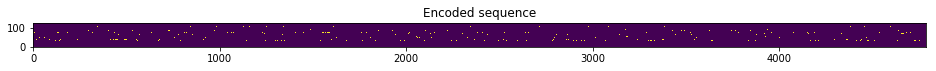

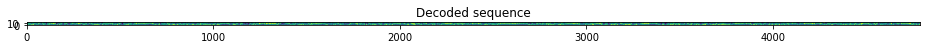

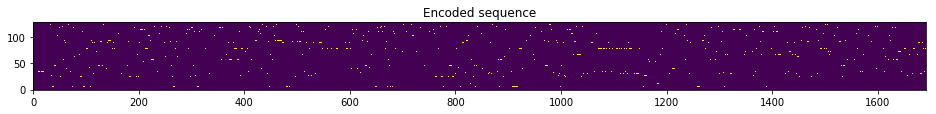

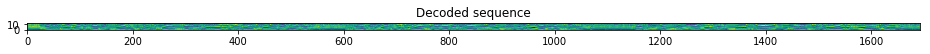

In [29]:
# Encode and decode train/test data and save
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

additional_feed = {tau_tf: tau_min, hard_discrete_handle_tf: True}

target_speaker_id = speaker_to_id["V001"]  #  "V001" or "V002" for target speakers
embed_dir = get_save_dir(output_dir, "embed", language, input_feats, output_feats,
                          seq_type, False, max_length, id_to_speaker[target_speaker_id])

embed_and_save(
    input_train, model_file,
    x_input_tf, x_lengths_tf, z_cat_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,
    speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_cat_vae", "train"),
    batch_size=100, shuffle=False, config=config,
    additional_feed=additional_feed, target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_test, model_file,
    x_input_tf, x_lengths_tf, z_cat_encoding_tf, decoder_output_tf,
    aux_encoding_dict=None,
    speaker_id=speaker_id_tf,
    output_dir=os.path.join(embed_dir, "many_to_many_cat_vae", "test"),
    batch_size=100, shuffle=False, config=config, additional_feed=additional_feed, target_speaker_id=target_speaker_id)

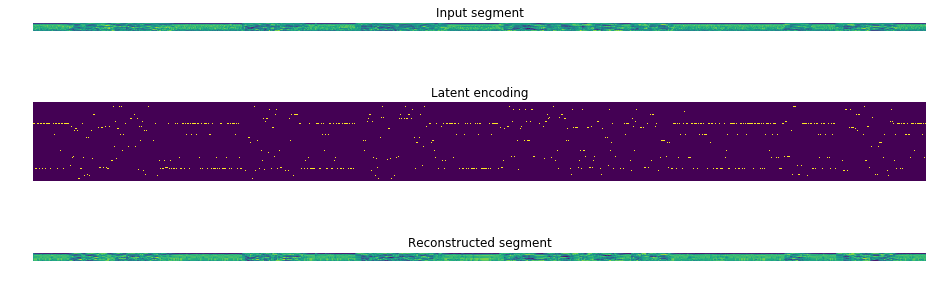

In [30]:
# Plot latent encodings and reconstructed output
plot_latent_reconstruction(*ex_batch, plot_indices=range(1), figsize=(16, 6), plot_vertical=True)